# This is only using the wildfire images from the orange dot and manual csv and dates that don't have clouds csv

In [1]:
import pandas as pd
import os

### Get wildfire dates

In [2]:
path = 'images/'
filename = 'wildfires_orange_dot_and_manual.csv'

In [3]:
df_wildfires = pd.read_csv(os.path.join(path, filename))

In [4]:
df_wildfires['date'] = pd.to_datetime(df_wildfires['date'])

In [5]:
df2_wildfires = df_wildfires.sort_values(by='date')

In [6]:
df_wildfires.dtypes

date         datetime64[ns]
wildfires             int64
dtype: object

In [7]:
df_wildfires['ConvertedDate'] = df_wildfires['date'].dt.strftime('%Y-%m-%d')

In [8]:
df_wildfires = df_wildfires.drop(['date'], axis = 1)

In [9]:
df_wildfires = df_wildfires.assign(wildfires=1)

In [10]:
df_wildfires = df_wildfires[['ConvertedDate','wildfires']]

In [11]:
len(df_wildfires)

426

### Get dates with minimal cloud coverage
* no_cloudy_dates_list_1_13_2022.csv

In [12]:
path = '/images/'
filename = 'no_cloudy_dates_list_1_13_2022.csv'

In [13]:
df_no_clouds = pd.read_csv(os.path.join(path, filename))

In [14]:
df_no_clouds['date'] = pd.to_datetime(df_no_clouds['Date'])

In [15]:
df_no_clouds = df_no_clouds.drop(['Unnamed: 0'], axis = 1)

In [16]:
df_no_clouds2 = df_no_clouds.sort_values(by='date')

In [17]:
df_no_clouds = df_no_clouds2.drop(['Date'], axis = 1)

In [18]:
df_no_clouds.dtypes

Clouds             int64
date      datetime64[ns]
dtype: object

In [19]:
df_no_clouds['ConvertedDate'] = df_no_clouds['date'].dt.strftime('%Y-%m-%d')

In [20]:
df_no_clouds = df_no_clouds.drop(['date'], axis = 1)

In [21]:
len(df_no_clouds)

3249

In [22]:
df_no_clouds = df_no_clouds[['ConvertedDate','Clouds']]

### Go through df_no_clouds and make sure there are no dates that are also in df_wildfires because the model will need labeled images. The dates in df_no_clouds are just going to be labeled as no wildfire, whereas the dates in df_wildfires will be labeled as wildfire

In [23]:
df_dates_in_both = pd.merge(df_no_clouds,df_wildfires, on=['ConvertedDate'],indicator='Exist')

In [24]:
df_no_clouds_no_wildfires = pd.merge(df_no_clouds,df_wildfires,indicator=True,how='outer').query('_merge=="left_only"').drop('_merge',axis=1)

In [25]:
len(df_no_clouds_no_wildfires)

2828

In [26]:
#df_wildfires = df_wildfires[:40]
#df_no_clouds_no_wildfires = df_no_clouds_no_wildfires[:100]

### df_no_clouds_no_wildfires should not have any of the dates in df_dates_in_both
* It does not so that is good

## Just need to work with df_wildfires and df_no_clouds_no_wildfires

### Get the dependent variables images

In [27]:
from PIL import Image
from skimage.io import imshow, imread

In [28]:
images_wo_fire_labels_path = '/images/images_wo_fire_labels/'

### Get the images of the dates that have wildfires

In [29]:
wildfire_images = []

for index, row in df_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    wildfire_images.append(im)

### Get images of dates that don't have a wildfire or much cloud coverage

In [30]:
no_wildfire_images = []

for index, row in df_no_clouds_no_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images.append(im)

### If the images are not the same shape then making the data np arrays will fail and even if you are able to convert them to np arrays the NN will fail
* Inspect the images to ensure the shape sizes are all the same
* This is very interesting because some of the errors have a perfectly fine image
* I realized this because I was searching for this error when trying to fit the NN: 
    * ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray)
* I actually realized that when trying to do this:
    * x_train = np.asarray(combined_x_train)
    * x_test = np.asarray(combined_x_test)
    * I was getting this error because not all the shapes were the same size:
        * And I had been seeing this VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [31]:
for i in range(len(wildfire_images)):
    if wildfire_images[i].shape[0] != 180:
        print('error')
    if wildfire_images[i].shape[1] != 182:
        print('i not 182: ', i)
    if wildfire_images[i].shape[2] != 3:
        print('i not 3: ', i)

In [32]:
bad_images =[]
for i in range(len(no_wildfire_images)):
    if no_wildfire_images[i].shape[0] != 180 or no_wildfire_images[i].shape[1] != 182 or no_wildfire_images[i].shape[2] != 3:
        #print('i not 180: ', i, 'shape is: ', no_wildfire_images[i].shape[0])
        #print('i not 182: ', i, 'shape is: ', no_wildfire_images[i].shape[1])
        #print('i not 3: ', i, 'shape is: ', no_wildfire_images[i].shape[2])
        bad_images.append(i)

In [33]:
# Example just looking at a few previous bad images
#df_no_clouds_no_wildfires.loc[188]#: 2013-12-10 image looks fine

In [34]:
#df_no_clouds_no_wildfires.loc[2787]

In [35]:
import matplotlib.pyplot as plt

In [36]:
#img = plt.imshow(no_wildfire_images[1578])

### Drop the "bad" images from no_wildfire_images

In [37]:
no_wildfire_images = []

count = 0
for index, row in df_no_clouds_no_wildfires.iterrows():
    if count not in bad_images:
        image_date = row['ConvertedDate']
        jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
        im = imread(jpeg_file)
        no_wildfire_images.append(im)
    count+=1

In [38]:
len(no_wildfire_images)

2802

### Get the independent variable images

In [39]:
x_all_images = wildfire_images + no_wildfire_images

In [40]:
y_wildfires = []
for i in range(len(wildfire_images)):
    y_wildfires.append(1)

In [41]:
y_no_wildfires = []
for i in range(len(no_wildfire_images)):
    y_no_wildfires.append(0)

In [42]:
y_all = y_wildfires + y_no_wildfires

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_all_images, y_all, test_size=0.33, random_state=42)

### Make data a numpy array

In [45]:
import numpy as np

In [46]:
print(type(X_train))
print(type(X_train[0]))
print(X_train[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
(180, 182, 3)


In [47]:
x_train = np.asarray(X_train)
x_test = np.asarray(X_test)

In [48]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [49]:
print('type(x_train): ',type(x_train))
print('len(x_train): ',len(x_train))
print('type(x_train[0]): ',type(x_train[0]))
print('type(x_test): ',type(x_test))
print('len(x_test): ',len(x_test))
print('type(x_test[0]): ',type(x_test[0]))
print('type(y_train): ',type(y_train))
print('len(y_train): ', len(y_train))
print('type(y_train[0]): ',type(y_train[0]))
print('y_train[0]: ',y_train[0])
print('type(y_test): ',type(y_test))
print('len(y_test): ',len(y_test))
print('type(y_test[0]): ',type(y_test[0]))
print('y_test[0]: ',y_test[0])

type(x_train):  <class 'numpy.ndarray'>
len(x_train):  2162
type(x_train[0]):  <class 'numpy.ndarray'>
type(x_test):  <class 'numpy.ndarray'>
len(x_test):  1066
type(x_test[0]):  <class 'numpy.ndarray'>
type(y_train):  <class 'numpy.ndarray'>
len(y_train):  2162
type(y_train[0]):  <class 'numpy.int64'>
y_train[0]:  0
type(y_test):  <class 'numpy.ndarray'>
len(y_test):  1066
type(y_test[0]):  <class 'numpy.int64'>
y_test[0]:  0


___

### Import libraries for ML

In [50]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
#from keras.utils import to_categorical
plt.style.use('fivethirtyeight')

### Shape

In [51]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('x_test shape:', x_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (2162, 180, 182, 3)
y_train shape: (2162,)
x_test shape: (1066, 180, 182, 3)
y_test shape: (1066,)


In [52]:
# First image. Shows the image as a series of pixel values
#x_train[0]

In [53]:
# Looking at the first image using matplotlib
# This doesn't work when you convert the values to astype(np.float32)
#img = plt.imshow(x_train[0])

In [54]:
# Print the label of the image. It is either a 0, no wildfire, or 1, wildfire
print('label of the image: ', y_train[0])

label of the image:  0


### Convert labels to a set of 2 numbers using one-hot encoding to input into the NN

In [55]:
from tensorflow.keras.utils import to_categorical

In [56]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [57]:
print('label of the image: ', y_train_one_hot[0])

label of the image:  [1. 0.]


### Normalize the pixels

In [58]:
x_train = x_train / 255
x_test = x_test / 255

In [59]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('x_test shape:', x_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (2162, 180, 182, 3)
y_train shape: (2162,)
x_test shape: (1066, 180, 182, 3)
y_test shape: (1066,)


In [60]:
#x_train[0]

### Reshape X_train and X_test because getting: Found array with dim 4. Estimator expected <= 2.

In [60]:
print(type(x_train))
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


In [61]:
x_train_len = len(x_train)
x_test_len = len(x_test)
x_train = x_train.reshape(x_train_len,180 * 182 * 3)
x_test = x_test.reshape(x_test_len,180 * 182 * 3)

In [62]:
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error
# Gridsearch
from sklearn.model_selection import GridSearchCV
# Validating the model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn import metrics

In [63]:
# 'hidden_layer_sizes': [1,2,3,4,5,6,7,8,9,10,20,30,40]
#tuned_parameters = [{'hidden_layer_sizes': [10,20,30,40],'activation': ['relu'],'solver':['lbfgs'], 'alpha':[0.0001],'batch_size':['auto'], 'learning_rate':['constant'],'learning_rate_init':[0.001], 'max_iter':[500]}]

tuned_parameters = [{'hidden_layer_sizes': [10,20,30,40],'activation': ['relu'],'solver':['adam'], 'alpha':[0.0001],'batch_size':['auto'], 'learning_rate':['constant'],'learning_rate_init':[0.001], 'max_iter':[500],'n_iter_no_change':[10]}]

gsc = GridSearchCV(MLPClassifier(), tuned_parameters, cv=5)
grid_result = gsc.fit(x_train, y_train)
best_params_new = grid_result.best_params_
 
mlp = MLPClassifier(hidden_layer_sizes=best_params_new['hidden_layer_sizes'], activation=best_params_new['activation'], solver=best_params_new['solver'], alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, max_iter=500,n_iter_no_change=10)
mlp.fit(x_train,y_train)

MLPClassifier(hidden_layer_sizes=20, max_iter=500)

In [64]:
train_mse = mean_squared_error(y_train, gsc.predict(x_train))
test_mse = mean_squared_error(y_test, gsc.predict(x_test))
 
print(gsc.best_params_)
print(gsc.best_score_)
print("Train MSE:", np.round(train_mse,4))
print("Test MSE:", np.round(test_mse,4))

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'hidden_layer_sizes': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 500, 'n_iter_no_change': 10, 'solver': 'adam'}
0.8718715251047815
Train MSE: 0.1258
Test MSE: 0.1445


In [65]:
scoring_values = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# K-Fold Cross Validation
# After creating a random forest regressor object, we pass it to the cross_val_score() function which performs K-Fold cross validation 
scores = cross_validate(mlp, x_train, y_train, cv = 5, scoring = scoring_values)
print("scores : ", scores)

# To get the list of values predicted using the model
# predictions = cross_val_predict(best_mlp, IVs, DV, cv = 5)

scores :  {'fit_time': array([139.68577313, 406.23984623,  15.2200768 , 262.96053386,
        15.1438899 ]), 'score_time': array([0.046453  , 0.04729486, 0.04940915, 0.04692721, 0.04668713]), 'test_abs_error': array([-0.1108545 , -0.12702079, -0.125     , -0.125     , -0.875     ]), 'test_squared_error': array([-0.1108545 , -0.12702079, -0.125     , -0.125     , -0.875     ]), 'test_r2': array([ 2.88600289e-04, -1.45502646e-01, -1.42857143e-01, -1.42857143e-01,
       -7.00000000e+00])}


In [67]:
mlp.predict_proba(x_test[:1])

array([[0.84991611, 0.15008389]])

In [68]:
mlp.predict(x_test[:5,:])

array([0, 0, 0, 0, 0])

In [69]:
mlp.score(x_test,y_test)

0.8555347091932458

# Model Validation - Note: This is on images used to train/test because I know what images have fires and don't

In [77]:
import random

In [79]:
len(df_no_clouds_no_wildfires)

2828

In [80]:
# Load an image you want to classify from an image file
# I'm just getting 4 random dates where there are no wildfires and where there were wildfires
fire_1 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_2 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_3 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_4 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
no_fire_1 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_2 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_3 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_4 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]

In [81]:
no_fire_validation_dates = [no_fire_1,no_fire_2,no_fire_3,no_fire_4]
fire_validation_dates = [fire_1,fire_2,fire_3,fire_4]

In [82]:
no_fire_validation_dates

['2012-05-12', '2012-03-06', '2019-01-29', '2017-08-05']

In [83]:
no_wildfire_images_validation = []

for i in no_fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images_validation.append(im)

In [84]:
wildfire_images_validation = []

for i in fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_validation.append(im)

#### Resize Images for prediction

In [85]:
from skimage.transform import resize

In [92]:
x_train_len

2162

In [95]:
no_wildfire_images_validation_array = np.asarray(no_wildfire_images_validation)

In [96]:
resized_images_no_fire = no_wildfire_images_validation_array.reshape(len(no_wildfire_images_validation),180 * 182 * 3)

In [116]:
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(mlp.predict_proba([resized_images_no_fire[i]]))

In [117]:
actual_wildfire_predictions

[array([[0.84991611, 0.15008389]]),
 array([[0.84991611, 0.15008389]]),
 array([[0.84991611, 0.15008389]]),
 array([[0.84991611, 0.15008389]])]

### Look at the images to see if there should be no wildfire

#### Get the labeled images for the specified dates

In [118]:
images_w_fire_labels_path = '/images/images_w_fire_labels/'

In [119]:
wildfire_images_w_label = []

for i in no_fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

In [120]:
actual_wildfire_predictions[0]

array([[0.84991611, 0.15008389]])

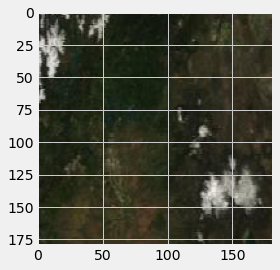

In [121]:
no_wildfire_image_0 = plt.imshow(no_wildfire_images_validation[0])

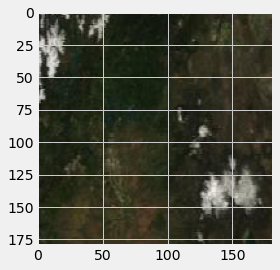

In [122]:
labeled_no_wildfire_image_0 = plt.imshow(wildfire_images_w_label[0])

In [123]:
actual_wildfire_predictions[1]

array([[0.84991611, 0.15008389]])

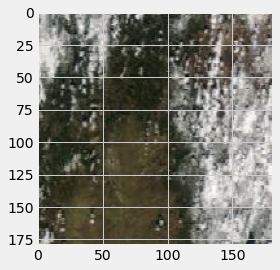

In [124]:
no_wildfire_image_1 = plt.imshow(no_wildfire_images_validation[1])

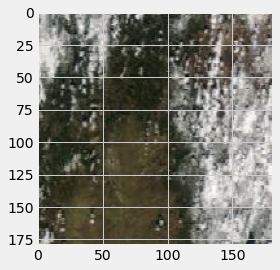

In [125]:
labeled_no_wildfire_image_1 = plt.imshow(wildfire_images_w_label[1])

In [126]:
actual_wildfire_predictions[2]

array([[0.84991611, 0.15008389]])

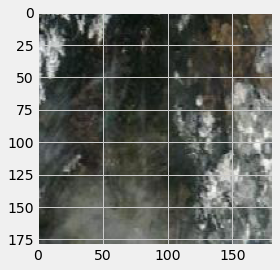

In [127]:
no_wildfire_image_2 = plt.imshow(no_wildfire_images_validation[2])

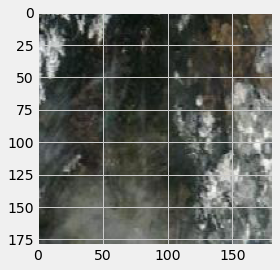

In [128]:
labeled_no_wildfire_image_2 = plt.imshow(wildfire_images_w_label[2])

In [129]:
actual_wildfire_predictions[3]

array([[0.84991611, 0.15008389]])

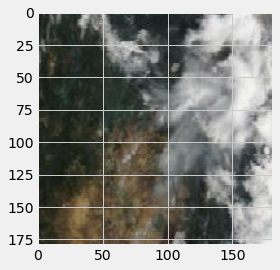

In [130]:
no_wildfire_image_3 = plt.imshow(no_wildfire_images_validation[3])

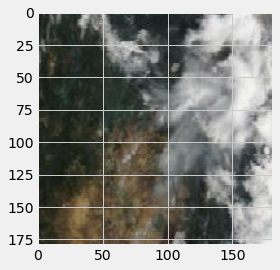

In [131]:
labeled_no_wildfire_image_3 = plt.imshow(wildfire_images_w_label[3])

### The below images were predicted to have wildfire and the labeled data should have the orange dot if there actually was a wildfire

In [132]:
wildfire_images_validation_array = np.asarray(wildfire_images_validation)

In [133]:
resized_images_w_fire = wildfire_images_validation_array.reshape(len(wildfire_images_validation),180 * 182 * 3)

In [134]:
actual_wildfire_predictions2 = []
for i in range(len(resized_images_w_fire)):
    actual_wildfire_predictions2.append(mlp.predict_proba([resized_images_w_fire[i]]))

In [135]:
actual_wildfire_predictions2

[array([[0.84991611, 0.15008389]]),
 array([[0.84991611, 0.15008389]]),
 array([[0.84991611, 0.15008389]]),
 array([[0.84991611, 0.15008389]])]

#### Get the labeled data images

In [136]:
wildfire_images_w_label_2 = []

for i in fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label_2.append(im)

In [137]:
actual_wildfire_predictions2[0]

array([[0.84991611, 0.15008389]])

In [173]:
#wildfire_image_0 = plt.imshow(wildfire_images_validation[0])

In [174]:
#labeled_wildfire_image_0 = plt.imshow(wildfire_images_w_label_2[0])

In [150]:
actual_wildfire_predictions2[1]

array([[0.88550526, 0.11449475]], dtype=float32)

In [175]:
#wildfire_image_1 = plt.imshow(wildfire_images_validation[1])

In [176]:
#labeled_wildfire_image_1 = plt.imshow(wildfire_images_w_label_2[1])

In [153]:
actual_wildfire_predictions2[2]

array([[0.8735962 , 0.12640381]], dtype=float32)

In [177]:
#wildfire_image_2 = plt.imshow(wildfire_images_validation[2])

In [178]:
#labeled_wildfire_image_2 = plt.imshow(wildfire_images_w_label_2[2])

In [156]:
actual_wildfire_predictions2[3]

array([[0.94238216, 0.0576179 ]], dtype=float32)

In [179]:
#wildfire_image_3 = plt.imshow(wildfire_images_validation[3])

In [180]:
#labeled_wildfire_image_3 = plt.imshow(wildfire_images_w_label_2[3])

### Save the Model

In [ ]:
#model.save('mlp_model.h5')

### Load the Model

In [ ]:
from keras.models import load_model
#loaded_model = load_model('mlp_model.h5')

# Model 2

# Build the NN

#### To build the model we need to create the architecture using Sequential()

In [98]:
model = Sequential()

#### Next we add the first layer, a convolution layer to extract features from the input image, and create 32 5 x 5 ReLu convoluted features also known as feature maps. Since this is the first layer we must input the dimension shape which is a 180 x 182 pixel image with depth = 3 (RGB)

In [99]:
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(180,182,3)))

#### The next layer will be a pooling layer with a 2 x 2 pixel filter to get the max element from the feature maps. This reduces the dimension of the feature maps by half and is also known as sub sampling.

In [100]:
model.add(MaxPooling2D(pool_size=(2, 2)))

#### Create one more convolution layer and pooling layer like before, but without the input_shape

In [101]:
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#### Add a flattening layer, to reduce the image to a linear array also known as a one 1-Dimension vector to feed into and connect with the neural network.

In [102]:
model.add(Flatten())

#### Now create a neural network where the first layer has 1000 neurons and the activation function ReLu

In [103]:
model.add(Dense(1000, activation='relu'))

#### Add a drop out layer with 50% drop out

In [104]:
model.add(Dropout(0.5))

#### Now create a neural network where the first layer has 500 neurons and the activation function ReLu.

In [105]:
model.add(Dense(500, activation='relu'))

#### Add a drop out layer with 50% drop out.

In [106]:
model.add(Dropout(0.5))

#### Now create a neural network where the first layer has 250 neurons and the activation function ReLu.

In [107]:
model.add(Dense(250, activation='relu'))

#### Create the last layer of this neural network with 2 neurons (one for each label) using the softmax function.

In [108]:
model.add(Dense(2, activation='softmax'))

#### Compile the model. Give it the categorical_crossentropy loss function which is used for classes greater than 2, the adam optimizer, and the accuracy of the model.

In [109]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [112]:
print(len(wildfire_images)/len(no_wildfire_images))

0.15203426124197003


In [113]:
hist = model.fit(x_train, 
                 y_train_one_hot, 
                 batch_size=256, 
                 epochs=10, 
                 validation_split=0.2 )

Epoch 1/10
7/7 [==============================] - 42s 5s/step - loss: 1.2040 - accuracy: 0.6802 - val_loss: 0.3864 - val_accuracy: 0.8915
Epoch 2/10
7/7 [==============================] - 36s 5s/step - loss: 0.4140 - accuracy: 0.8699 - val_loss: 0.3435 - val_accuracy: 0.8915
Epoch 3/10
7/7 [==============================] - 36s 5s/step - loss: 0.3730 - accuracy: 0.8699 - val_loss: 0.3699 - val_accuracy: 0.8915
Epoch 4/10
7/7 [==============================] - 34s 5s/step - loss: 0.3790 - accuracy: 0.8699 - val_loss: 0.3611 - val_accuracy: 0.8915
Epoch 5/10
7/7 [==============================] - 33s 5s/step - loss: 0.3912 - accuracy: 0.8699 - val_loss: 0.3285 - val_accuracy: 0.8915
Epoch 6/10
7/7 [==============================] - 33s 5s/step - loss: 0.3757 - accuracy: 0.8699 - val_loss: 0.3484 - val_accuracy: 0.8915
Epoch 7/10
7/7 [==============================] - 33s 5s/step - loss: 0.3828 - accuracy: 0.8699 - val_loss: 0.3380 - val_accuracy: 0.8915
Epoch 8/10
7/7 [==================

## Metrics

#### models accuracy on the test data.

In [114]:
model.evaluate(x_test, y_test_one_hot)[0]

34/34 [==============================] - 8s 221ms/step - loss: 0.3849 - accuracy: 0.8555


0.3848748207092285

In [115]:
model.evaluate(x_test, y_test_one_hot)[1]

34/34 [==============================] - 7s 210ms/step - loss: 0.3849 - accuracy: 0.8555


0.8555347323417664

### Visualize the models accuracy for both the training and test data.

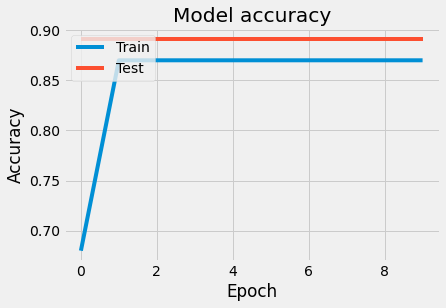

In [116]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Visualize the models loss for both the training and validation data.

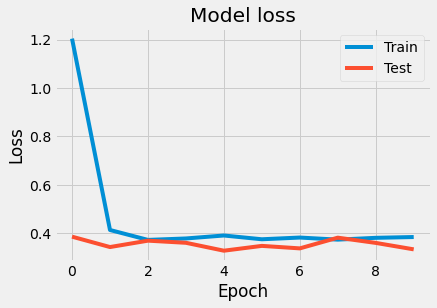

In [117]:
#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Model Validation

In [120]:
# Load an image you want to classify from an image file
# I'm just getting 4 random dates where there are no wildfires and where there were wildfires
fire_1 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_2 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_3 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
fire_4 = df_wildfires['ConvertedDate'][random.randrange(1,len(df_wildfires))]
no_fire_1 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_2 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_3 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]
no_fire_4 = df_no_clouds_no_wildfires['ConvertedDate'][random.randrange(1,len(df_no_clouds_no_wildfires))]

In [121]:
no_fire_validation_dates = [no_fire_1,no_fire_2,no_fire_3,no_fire_4]
fire_validation_dates = [fire_1,fire_2,fire_3,fire_4]

In [122]:
no_fire_validation_dates

['2018-12-08', '2018-11-17', '2013-02-14', '2012-05-07']

In [123]:
no_wildfire_images_validation = []

for i in no_fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images_validation.append(im)

In [124]:
wildfire_images_validation = []

for i in fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_validation.append(im)

#### Resize Images for prediction

In [125]:
from skimage.transform import resize

In [126]:
resized_images_no_fire = []

for i in range(len(no_wildfire_images_validation)):
    resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,182,3)))

In [127]:
# These should all be No wildfire
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(model.predict(np.array([resized_images_no_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [128]:
actual_wildfire_predictions

[array([[0.6904444 , 0.30955565]], dtype=float32),
 array([[0.6920095 , 0.30799046]], dtype=float32),
 array([[0.9190906 , 0.08090942]], dtype=float32),
 array([[0.9052607 , 0.09473936]], dtype=float32)]

### Look at the images to see if there should be no wildfire

#### Get the labeled images for the specified dates

In [129]:
images_w_fire_labels_path = '/images/images_w_fire_labels/'

In [130]:
wildfire_images_w_label = []

for i in no_fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

In [131]:
actual_wildfire_predictions[0]

array([[0.6904444 , 0.30955565]], dtype=float32)

In [165]:
#no_wildfire_image_0 = plt.imshow(no_wildfire_images_validation[0])

In [166]:
#labeled_no_wildfire_image_0 = plt.imshow(wildfire_images_w_label[0])

In [134]:
actual_wildfire_predictions[1]

array([[0.6920095 , 0.30799046]], dtype=float32)

In [167]:
#no_wildfire_image_1 = plt.imshow(no_wildfire_images_validation[1])

In [168]:
#labeled_no_wildfire_image_1 = plt.imshow(wildfire_images_w_label[1])

In [137]:
actual_wildfire_predictions[2]

array([[0.9190906 , 0.08090942]], dtype=float32)

In [169]:
#no_wildfire_image_2 = plt.imshow(no_wildfire_images_validation[2])

In [170]:
#labeled_no_wildfire_image_2 = plt.imshow(wildfire_images_w_label[2])

In [140]:
actual_wildfire_predictions[3]

array([[0.9052607 , 0.09473936]], dtype=float32)

In [171]:
#no_wildfire_image_3 = plt.imshow(no_wildfire_images_validation[3])

In [172]:
#labeled_no_wildfire_image_3 = plt.imshow(wildfire_images_w_label[3])

### The below images were predicted to have wildfire and the labeled data should have the orange dot if there actually was a wildfire

In [143]:
resized_images_w_fire = []

for i in range(len(wildfire_images_validation)):
    resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,182,3)))

In [144]:
# These should all be wildfire
actual_wildfire_predictions2 = []
for i in range(len(resized_images_w_fire)):
    actual_wildfire_predictions2.append(model.predict(np.array([resized_images_w_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [145]:
actual_wildfire_predictions2

[array([[0.77999854, 0.22000143]], dtype=float32),
 array([[0.88550526, 0.11449475]], dtype=float32),
 array([[0.8735962 , 0.12640381]], dtype=float32),
 array([[0.94238216, 0.0576179 ]], dtype=float32)]

#### Get the labeled data images

In [146]:
wildfire_images_w_label_2 = []

for i in fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label_2.append(im)

In [147]:
actual_wildfire_predictions2[0]

array([[0.77999854, 0.22000143]], dtype=float32)

In [173]:
#wildfire_image_0 = plt.imshow(wildfire_images_validation[0])

In [174]:
#labeled_wildfire_image_0 = plt.imshow(wildfire_images_w_label_2[0])

In [150]:
actual_wildfire_predictions2[1]

array([[0.88550526, 0.11449475]], dtype=float32)

In [175]:
#wildfire_image_1 = plt.imshow(wildfire_images_validation[1])

In [176]:
#labeled_wildfire_image_1 = plt.imshow(wildfire_images_w_label_2[1])

In [153]:
actual_wildfire_predictions2[2]

array([[0.8735962 , 0.12640381]], dtype=float32)

In [177]:
#wildfire_image_2 = plt.imshow(wildfire_images_validation[2])

In [178]:
#labeled_wildfire_image_2 = plt.imshow(wildfire_images_w_label_2[2])

In [156]:
actual_wildfire_predictions2[3]

array([[0.94238216, 0.0576179 ]], dtype=float32)

In [179]:
#wildfire_image_3 = plt.imshow(wildfire_images_validation[3])

In [180]:
#labeled_wildfire_image_3 = plt.imshow(wildfire_images_w_label_2[3])

### Save the Model

In [ ]:
#model.save('nn_model.h5')

### Load the Model

In [ ]:
from keras.models import load_model
#loaded_model = load_model('nn_model.h5')